#Variational Auto Encoder

##Imports 

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from IPython import display

##Parameters

In [3]:
#Define global constants to be used in this notebook
BATCH_SIZE = 128
LATENT_DIM = 2

##Prep the Dataset

Only use the `train` split of the MNIST dataset 

In [4]:
def map_image(image, label):
  """
  returns a normalized and reshaped tensor from a given image
  """

  image = tf.cast(image, dtype=tf.float32)
  image /= 255.0
  image = tf.reshape(image, shape=(28, 28, 1))
  return image 

def get_dataset(map_fn, is_validation=False):
  """
  Loads and prepares the mnist dataset from TFDS
  """

  if is_validation:
    split_name = 'test'
  else:
    split_name = 'train'

  dataset = tfds.load('mnist', as_supervised=True, split=split_name)
  dataset = dataset.map(map_image)

  if is_validation:
    dataset = dataset.batch(BATCH_SIZE)
  else:
    dataset = dataset.shuffle(1024).batch(BATCH_SIZE)

  return dataset

In [5]:
train_dataset = get_dataset(map_image)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.



Dl Completed...:   0%|          | 0/4 [00:00<?, ? file/s]


Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


##Build the Model

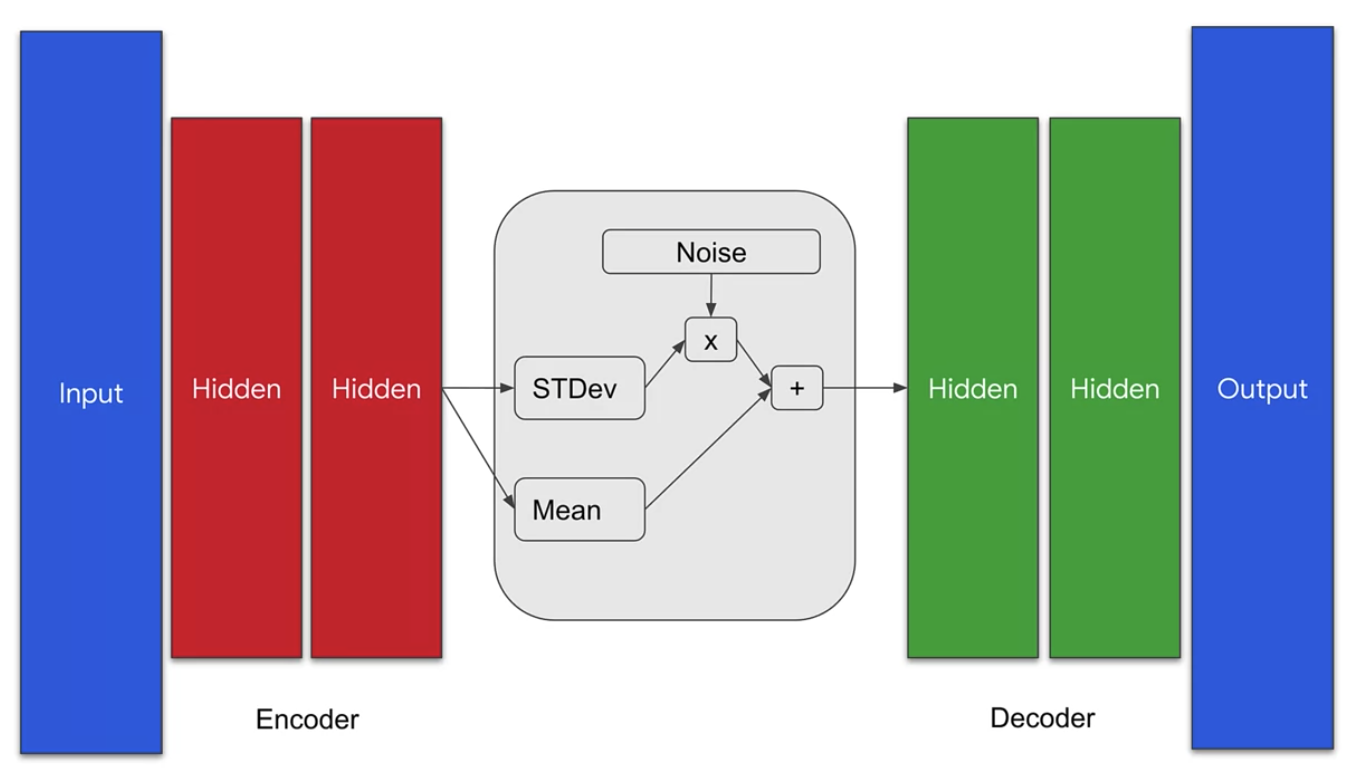

The VAE also has an encoder-decoder architecture witht the main difference being the grey box in the middle which stands for the latent representations
* In this layer, the model mixes a random sample and combines it with the outputs of the encoder. This mechanism makes it useful for generating new content

#Sampling Class
This is a custom Keras layer that will provide Gaussian noise input along with the mean (mu) and standard deviation (sigma) of the encoder's output

In [6]:
class Sampling(tf.keras.layers.Layer):
  def call(self, inputs):
    """
    Generates a random sample and combines with encoder output

    Args:
      inputs (tensor): output tensor from the encoder

    Returns:
      `inputs` (tensor): tensors combined with a random sample 
    """

    #Unpack the output of the encoder 
    mu, sigma = inputs 

    #get the size and dimensions of the batch 
    batch = tf.shape(mu)[0]
    dim = tf.shape(mu)[1]

    #generate a random tensor 
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))

    #combine the inputs and noise
    return mu + tf.exp(0.5 * sigma) * epsilon

##Encoder 

Next, build the encoder part of the network (right side of sampling layer). 

NOTE: Aside from mu and sigma, also output the shape of features before flattening it. This is useful when reconstructing the image later in the decoder 

NOTE: There might be issues when using batch normalization with smaller batches and sometimes it's better to avoid using batch normalization when training VAE's in particular
* Try adding or removing it from the network to see the effects 

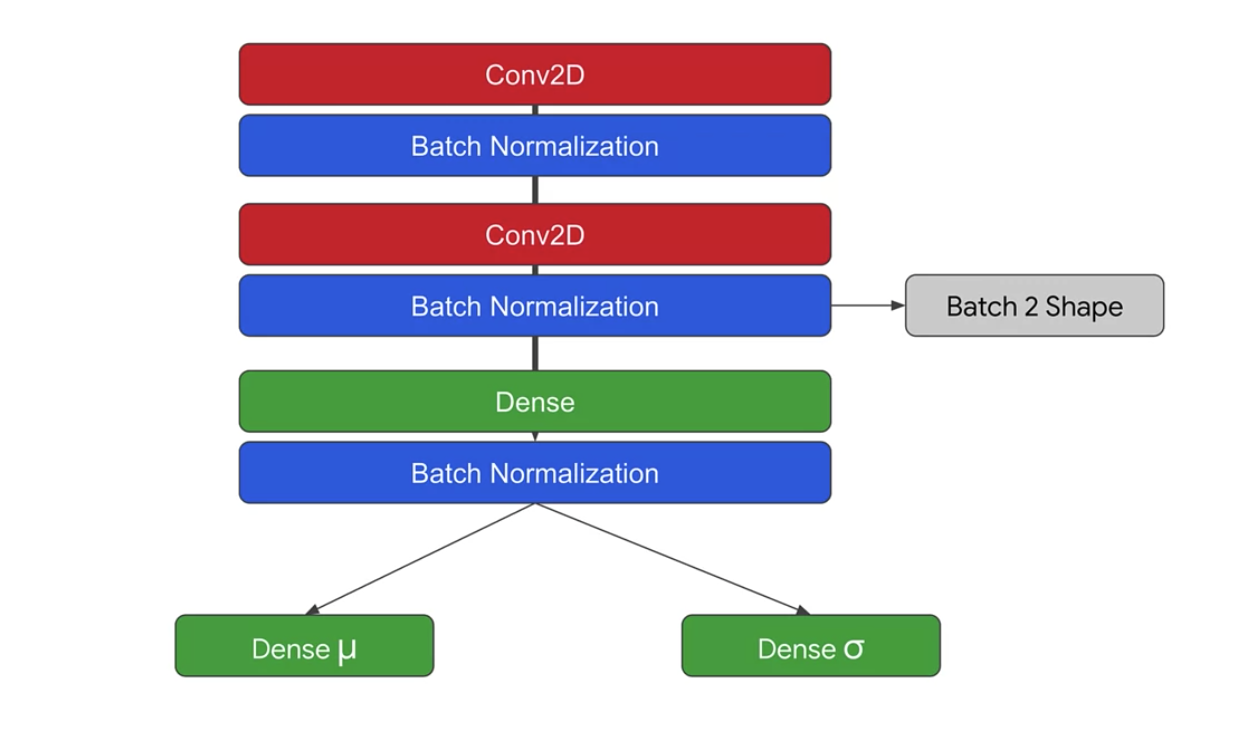

In [21]:
def encoder_layers(inputs, latent_dim):
  """Defines the encoder's layers
  Args:
    inputs -- batch from the dataset
    latent_dim -- dimensionality of the latent space
  
  Returns:
    mu -- learned mean
    sigma -- learned standard deviation
    batch_2.shape -- shape of the features before flattening
  """

  # add the Conv2D layers followed by BatchNormalization
  x = tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=2, padding="same", activation="relu", name="encode_conv1")(inputs)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=2, padding="same", activation="relu", name="encoder_conv2")(x)

  # assign to a different variable so you can extract the shape later
  batch_2 = tf.keras.layers.BatchNormalization()(x)


  # flatten the features and feed into the Dense network
  x = tf.keras.layers.Flatten(name="encode_flatten")(batch_2)

  # we arbitrarily used 20 units here but feel free to change and see what results you get
  x = tf.keras.layers.Dense(20, activation="relu", name="encoder_dense")(x)
  x = tf.keras.layers.BatchNormalization()(x)

  # add output Dense networks for mu and sigma, units equal to the declared latent_dim
  mu = tf.keras.layers.Dense(latent_dim, name="latent_mu")(x)
  sigma = tf.keras.layers.Dense(latent_dim, name="latent_sigma")(x)

  return mu, sigma, batch_2.shape

In [22]:
def encoder_model(latent_dim, input_shape):
  """Defines the encoder model with the Sampling layer

  Args:
    latent_dim -- dimensionality of the latent space
    input_shape -- shape of the dataset batch

  Returns:
    model -- the encoder model
    conv_shape -- shape of the features before flattening
  """

  # declare the inputs tensor with the given shape
  inputs = tf.keras.layers.Input(shape=input_shape)

  # get the output of the encoder_layers() function
  mu, sigma, conv_shape = encoder_layers(inputs, latent_dim=LATENT_DIM)

  # feed mu and sigma to the sampling layer
  z = Sampling()((mu, sigma))

  # build the whole encoder model
  model = tf.keras.Model(inputs=inputs, outputs=[mu, sigma, z])

  return model, conv_shape

##Decoder 

This part is responsible for expanding the latent representations back to the original image dimensions. Random inputs will be fed into this model that will generate content that resemble the training data

In [24]:
def decoder_layers(inputs, conv_shape):
  """Defines the decoder layer
  Args:
    inputs -- output of the decoder
    conv_shape -- shape of the features before flattening

  Returns:
    tensor containing the decoded output
  """

  # feed to a Dense network with units computed from the conv_shape dimensions
  units = conv_shape[1] * conv_shape[2] * conv_shape[3]
  x = tf.keras.layers.Dense(units, activation="relu", name="decode_dense1")(inputs)
  x = tf.keras.layers.BatchNormalization()(x)

  # reshape output using the conv_shape dimensions
  x = tf.keras.layers.Reshape((conv_shape[1], conv_shape[2], conv_shape[3]), name="decode_reshape")(x)

  # upsample the features back to the original dimensions
  x = tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding="same", activation="relu", name="decode_conv2d_2")(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding="same", activation="relu", name="decode_conv2d_3")(x)
  x =tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=3, strides=1, padding="same", activation="sigmoid", name="decode_final")(x)

  return x

  def decoder_model(latent_dim, conv_shape):
  """Defines the decoder model

  Args:
    latent_dim -- dimensionality of the latent space
    conv_shape -- shape of the features before flattening
  
  Returns:
    model -- the decoder model
  """

  # set the inputs to the shape of the latent space
  inputs = tf.keras.layers.Input(shape=(latent_dim,))

  # get the output of the decoder layers
  outputs = decoder_layers(inputs, conv_shape)

  # declare the inputs and outputs of the model
  model = tf.keras.Model(inputs, outputs)

  return model

IndentationError: ignored

In [25]:
def decoder_model(latent_dim, conv_shape):
  """
  Defines the decoder model

  Args:
    latent_dim: dimensionality of the latent space
    conv_shape: shape of the features before flattening 

  Returns:
    model: the decoder model
  """

  #Set the inputs to the shape of the latent space 
  inputs = tf.keras.layers.Input(shape=(latent_dim,))

  #Get the output of the decoder layers
  outputs = decoder_layers(inputs, conv_shape)

  #Declare the inputs and outputs of the model
  model = tf.keras.Model(inputs, outputs)

  return model

def decoder_model(latent_dim, conv_shape):
  """Defines the decoder model

  Args:
    latent_dim -- dimensionality of the latent space
    conv_shape -- shape of the features before flattening
  
  Returns:
    model -- the decoder model
  """

  # set the inputs to the shape of the latent space
  inputs = tf.keras.layers.Input(shape=(latent_dim,))

  # get the output of the decoder layers
  outputs = decoder_layers(inputs, conv_shape)

  # declare the inputs and outputs of the model
  model = tf.keras.Model(inputs, outputs)

  return model

##Kull-Leibler Divergence Loss





To improve the generative capacity of this model, it must take into account the random normal distribution intorduced in the latent space
* The Kullback-Leibler Divergence is computed and added to the reconstruction loss (function for this is defined below)

In [11]:
def kl_reconstruction_loss(inputs, outputs, mu, sigma):
  """
  Computes the Kullback-Leibler Divergence (KLD)

  Args:
    inputs: batch from the dataset 
    outputs: batch from the sampling layer
    mu: mean
    sigma: standard div.

  Returns:
    KLD loss
  """

  #I barely understand this loss (probably don't understand it at all)
  k1_loss = 1 + sigma - tf.square(mu) - tf.math.exp(sigma)
  k1_loss = tf.reduce_mean(k1_loss) * -0.5
  
  return k1_loss

#VAE Model

Use the use of `model.add.loss()` tp add the KL reconstruction loss. Computing this loss doesn't `y_true` and `y_pred` so it can't be used in model.compile()

In [26]:
def vae_model(encoder, decoder, input_shape):
  """Defines the VAE model
  Args:
    encoder -- the encoder model
    decoder -- the decoder model
    input_shape -- shape of the dataset batch

  Returns:
    the complete VAE model
  """

  # set the inputs
  inputs = tf.keras.layers.Input(shape=input_shape)

  # get mu, sigma, and z from the encoder output
  mu, sigma, z = encoder(inputs)

  # get reconstructed output from the encoder
  reconstructed = decoder(z)

  # define the inputs and outputs to the VAE
  model = tf.keras.Model(inputs=inputs, outputs=reconstructed)

  # add the KL loss
  loss = kl_reconstruction_loss(inputs, z, mu, sigma)
  model.add_loss(loss)

  return model

helper function to setup and get the different models from the funcitons that were defined 

In [28]:
def get_models(input_shape, latent_dim):
  """Returns the encoder, decoder, and vae models"""
  encoder, conv_shape = encoder_model(latent_dim=latent_dim, input_shape=input_shape)
  decoder = decoder_model(latent_dim=latent_dim, conv_shape=conv_shape)
  vae = vae_model(encoder, decoder, input_shape=input_shape)
  return encoder, decoder, vae
# Get the encoder, decoder and 'master' model (called vae)
encoder, decoder, vae = get_models(input_shape=(28,28,1,), latent_dim=LATENT_DIM)

##Train the Model
Setup the VAE model for training 
* Define the reconstruction loss, optimizer, and metric

In [29]:
# Define our loss functions and optimizers
optimizer = tf.keras.optimizers.Adam()
loss_metric = tf.keras.metrics.Mean()
bce_loss = tf.keras.losses.BinaryCrossentropy()

The function below will generate the image at each epoch for a total of 16 image on a 4 x 4 grid 

In [18]:
def generate_and_save_images(model, epoch, step, test_input):
  """Helper function to plot our 16 images

  Args:

  model -- the decoder model
  epoch -- current epoch number during training
  step -- current step number during training
  test_input -- random tensor with shape (16, LATENT_DIM)
  """

  # generate images from the test input
  predictions = model.predict(test_input)

  # plot the results
  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0], cmap='gray')
      plt.axis('off')

  # tight_layout minimizes the overlap between 2 sub-plots
  fig.suptitle("epoch: {}, step: {}".format(epoch, step))
  plt.savefig('image_at_epoch_{:04d}_step{:04d}.png'.format(epoch, step))
  plt.show()

The training loop is below and will display generated images at each epoch. The training will take about 30 min to complete. 
* The KL-loss will be added to the binary crossentropy loss before getting the gradients and updating the weights 
* The initial 16 images will look random but will improve overtime as the network learns 

#Training Loop 


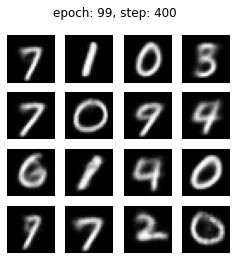

Epoch: 99 step: 400 mean loss = 143.16208


In [30]:
# Training loop

# generate random vector as test input to the decoder
random_vector_for_generation = tf.random.normal(shape=[16, LATENT_DIM])

# number of epochs
epochs = 100

# initialize the helper function to display outputs from an untrained model
generate_and_save_images(decoder, 0, 0, random_vector_for_generation)

for epoch in range(epochs):
  print('Start of epoch %d' % (epoch, ))

  # iterate over the batches of the dataset
  for step, x_batch_train in enumerate(train_dataset):
    with tf.GradientTape() as tape:
      # feed a batch to the VAE model
      reconstructed = vae(x_batch_train)

      # compute reconstruction loss
      flattened_inputs = tf.reshape(x_batch_train, shape=[-1])
      flattened_outputs = tf.reshape(reconstructed, shape=[-1])
      loss = bce_loss(flattened_inputs, flattened_outputs) * 784  # image size (28 * 28 * 1)
      
      # add KLD regularization loss
      loss += sum(vae.losses)

    # get the gradients and update the weights
    grads = tape.gradient(loss, vae.trainable_weights)
    optimizer.apply_gradients(zip(grads, vae.trainable_weights))

    # compute the loss metric
    loss_metric(loss)

    # display outputs every 100 steps
    if step % 100 == 0:
      display.clear_output(wait=False)
      generate_and_save_images(decoder, epoch, step, random_vector_for_generation)
      print('Epoch: %s step: %s mean loss = %s' % (epoch, step, loss_metric.result().numpy()))

In [31]:
import zipfile
import glob
# create gifs
zipf = zipfile.ZipFile('./vea.zip', 'w', zipfile.ZIP_DEFLATED)

filenames = glob.glob('./content/image_at_epoch_*.png')
filenames = sorted(filenames)

for filename in filenames:
    zipf.write(filename)

zipf.close()
import imageio

imageio.plugins.freeimage.download()

!rm -rf ./results/vea-mnist-anim.gif

anim_file = './vea-mnist-anim.gif'

filenames = glob.glob('/content/image_at_epoch_*.png')
filenames = sorted(filenames)
last = -1
images = []

for filename in filenames:
    image = imageio.imread(filename)
    images.append(image)

imageio.mimsave(anim_file, images, 'GIF-FI', fps=10)

Imageio: 'libfreeimage-3.16.0-linux64.so' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/freeimage/libfreeimage-3.16.0-linux64.so (4.6 MB)
Downloading: 8192/4830080 bytes (0.2%)2146304/4830080 bytes (44.4%)4830080/4830080 bytes (100.0%)
  Done
File saved as /root/.imageio/freeimage/libfreeimage-3.16.0-linux64.so.
